In [11]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from helper.helper_functions import load_dataset, save_model, get_features_and_target, encode_all_features, get_train_test_with_excluded_columns
from helper.clfmodel_functions import tune_model, seq_feat_selection, multi_metric_cv, plot_multi_score_cv_results, forward_feat_selection_hypertuning
from helper.fairness_functions import print_male_female_metrics, get_male_female_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

### Loading the cleaned dataset

In [12]:
data = load_dataset('../data/assignment2_income_cleaned.xlsx')

### Feature Engineering (encoding) & Train-Test Split

In [13]:
# Splitting the data into features (X) and target (y)
X, y = get_features_and_target(data, 'income')
X_male, X_female = get_male_female_data(X, False)
columns_to_exclude = ['age', 'ability to speak english', 'gave birth this year']
# Encoding the features and target
X_encoded, y_encoded = encode_all_features(X, y, [])
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [14]:
X_train.head()

,age,education,workinghours,ability to speak english,gave birth this year_No,gave birth this year_Yes,marital status_Divorced,marital status_Husband,marital status_Never married,marital status_Separated,...,occupation_Management/Business,occupation_Military Services,occupation_Office/Administrative Support,occupation_Production/Assembly,occupation_Protective Services,occupation_Repair/Maintenance,occupation_Sales,"occupation_Science, Engineering, Technology",occupation_Service/Hospitality,occupation_Transport
6317,22,16,36,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
740,61,22,40,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3781,48,16,40,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7850,62,18,65,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2963,53,19,44,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Model

Here, we quickly train and evaluate a KNN model with random parameters for demonstration.

In [15]:
# K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_preds)

print(classification_report(y_test, knn_preds))
print("K-Nearest Neighbors Accuracy:", knn_accuracy)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1175
           1       0.62      0.62      0.62       625

    accuracy                           0.73      1800
   macro avg       0.71      0.71      0.71      1800
weighted avg       0.74      0.73      0.74      1800

K-Nearest Neighbors Accuracy: 0.735


### Feature Importance using the model itself

In [16]:
seq_feat_selection(KNeighborsClassifier(), X_train, y_train)

Selected features:
Feature 1: education
Feature 2: workinghours
Feature 3: ability to speak english
Feature 4: gave birth this year_Yes
Feature 5: marital status_Divorced
Feature 6: marital status_Husband
Feature 7: marital status_Never married
Feature 8: marital status_Separated
Feature 9: marital status_Widowed
Feature 10: marital status_Wife
Feature 11: sex_Male
Feature 12: workclass_governmental
Feature 13: workclass_no paid work
Feature 14: workclass_private
Feature 15: workclass_self employed
Feature 16: occupation_Construction/Extraction
Feature 17: occupation_Counseling/Mental Health Services
Feature 18: occupation_Education
Feature 19: occupation_Entertainment
Feature 20: occupation_Farming, Fishing, Forestry
Feature 21: occupation_Finance/Accounting
Feature 22: occupation_Legal Services
Feature 23: occupation_Management/Business
Feature 24: occupation_Military Services
Feature 25: occupation_Office/Administrative Support
Feature 26: occupation_Production/Assembly
Feature 27: 

### Hyperparameter tuning

Here, we define the base parameter grid for our hyperparameter tuning function.

In [17]:
param_grid = {
        'n_neighbors': np.arange(2, 31, 1),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

Below, we tune the hyperparameters of the KNN model using the defined parameter grid and using all features.

In [18]:
best_params, best_model, best_accuracy = tune_model(KNeighborsClassifier(), X_encoded, X_train, y_train, X_test, y_test, param_grid)

print("Best Hyperparameters:", best_params)
print("Best Model:", best_model)
print("Best Model Accuracy:", best_accuracy)

knn_preds = best_model.predict(X_test)
print(classification_report(y_test, knn_preds))

print_male_female_metrics(best_model, X, X_male, X_female, X_test, y_test)
save_model(best_model, '../output/saved_models/knn_model_sexincl_noffs_tuned_unfair.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best Hyperparameters: {'n_neighbors': 22, 'p': 1, 'weights': 'uniform'}
Best Model: KNeighborsClassifier(n_neighbors=22, p=1)
Best Model Accuracy: 0.7605555555555555
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1175
           1       0.67      0.61      0.64       625

    accuracy                           0.76      1800
   macro avg       0.74      0.73      0.73      1800
weighted avg       0.76      0.76      0.76      1800
Fairness Metrics:
Male FPR: 0.22849083215796898
Male TPR: 0.6933867735470942
Female FPR: 0.060085836909871244
Female TPR: 0.30158730158730157

Disparate Impact (DI): 0.265
Discrimination Score (DS): -0.309
Equal Opportunity Difference (EO): 0.392
Equalized Odds (EOdds): 0.168


Now the same but with fairness constraints.

In [19]:
best_params, best_model, best_composite_metric = tune_model(KNeighborsClassifier(), X_encoded, X_train, y_train, X_test, y_test, param_grid, ensure_fairness=True)

print("Best Hyperparameters:", best_params)
print("Best Model:", best_model)
print("Best Model Accuracy:", best_composite_metric)

knn_preds = best_model.predict(X_test)
print(classification_report(y_test, knn_preds))

print_male_female_metrics(best_model, X, X_male, X_female, X_test, y_test)
save_model(best_model, '../output/saved_models/knn_model_sexincl_noffs_tuned_fair.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best Hyperparameters: {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}
Best Model: KNeighborsClassifier(n_neighbors=30)
Best Model Accuracy: 0.7538888888888889
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1175
           1       0.66      0.59      0.62       625

    accuracy                           0.75      1800
   macro avg       0.73      0.72      0.72      1800
weighted avg       0.75      0.75      0.75      1800
Fairness Metrics:
Male FPR: 0.2073342736248237
Male TPR: 0.6452905811623246
Female FPR: 0.08583690987124463
Female TPR: 0.373015873015873

Disparate Impact (DI): 0.379
Discrimination Score (DS): -0.241
Equal Opportunity Difference (EO): 0.272
Equalized Odds (EOdds): 0.121


As we can see in the general case, the second model scores considerably better in terms of fairness metrics, while the accuracy is slightly lower.

Below, we tune the hyperparameters of the KNN model using the defined parameter grid and using a **subset of features**. We exclude the columns 'age', 'ability to speak english', and 'workclass'.

In [20]:
# Splitting the data into features (X) and target (y)
X_, y_ = get_features_and_target(data, 'income')
columns_to_exclude = ['age', 'ability to speak english', 'workclass']
X_ = X_.drop(columns=columns_to_exclude)
# Encoding the features and target, and excluding some columns
X_encoded_, y_encoded_ = encode_all_features(X_, y_, columns_to_exclude)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_encoded_, y_encoded_, test_size=0.2, random_state=42)

best_params, best_model, best_accuracy = tune_model(KNeighborsClassifier(), X_encoded, X_train_, y_train_, X_test_, y_test_, param_grid)

print("\nBest Hyperparameters:", best_params)
print("Best Model:", best_model)
print("Best Model Accuracy:", best_accuracy)

preds = best_model.predict(X_test_)
print(classification_report(y_test_, preds))

print_male_female_metrics(best_model, X, X_male, X_female, X_test_, y_test_)
save_model(best_model, '../output/saved_models/knn_model_sexincl_noffs_tuned_unfair_aawexcl.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits

Best Hyperparameters: {'n_neighbors': 27, 'p': 1, 'weights': 'uniform'}
Best Model: KNeighborsClassifier(n_neighbors=27, p=1)
Best Model Accuracy: 0.7738888888888888
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1175
           1       0.69      0.64      0.66       625

    accuracy                           0.77      1800
   macro avg       0.75      0.74      0.75      1800
weighted avg       0.77      0.77      0.77      1800
Fairness Metrics:
Male FPR: 0.20451339915373765
Male TPR: 0.6933867735470942
Female FPR: 0.07939914163090128
Female TPR: 0.42857142857142855

Disparate Impact (DI): 0.378
Discrimination Score (DS): -0.253
Equal Opportunity Difference (EO): 0.265
Equalized Odds (EOdds): 0.125


Now the same but with fairness constraints.

In [21]:
# Splitting the data into features (X) and target (y)
X_, y_ = get_features_and_target(data, 'income')
columns_to_exclude = ['age', 'ability to speak english', 'workclass']
X_ = X_.drop(columns=columns_to_exclude)
# Encoding the features and target, and excluding some columns
X_encoded_, y_encoded_ = encode_all_features(X_, y_, columns_to_exclude)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_encoded_, y_encoded_, test_size=0.2, random_state=42)

best_params, best_model, best_accuracy = tune_model(KNeighborsClassifier(), X_encoded, X_train_, y_train_, X_test_, y_test_, param_grid, ensure_fairness=True)

print("\nBest Hyperparameters:", best_params)
print("Best Model:", best_model)
print("Best Model Accuracy:", best_accuracy)

preds = best_model.predict(X_test_)
print(classification_report(y_test_, preds))

print_male_female_metrics(best_model, X, X_male, X_female, X_test_, y_test_)
save_model(best_model, '../output/saved_models/knn_model_sexincl_noffs_tuned_fair_aawexcl.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits

Best Hyperparameters: {'n_neighbors': 26, 'p': 2, 'weights': 'uniform'}
Best Model: KNeighborsClassifier(n_neighbors=26)
Best Model Accuracy: 0.7727777777777778
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1175
           1       0.70      0.61      0.65       625

    accuracy                           0.77      1800
   macro avg       0.75      0.74      0.74      1800
weighted avg       0.77      0.77      0.77      1800
Fairness Metrics:
Male FPR: 0.18758815232722145
Male TPR: 0.6633266533066132
Female FPR: 0.07510729613733906
Female TPR: 0.42063492063492064

Disparate Impact (DI): 0.387
Discrimination Score (DS): -0.235
Equal Opportunity Difference (EO): 0.243
Equalized Odds (EOdds): 0.112


#### Forward Feature Selection with Hyperparameter Tuning

Because hyperparameter tuning results can vary depending on the chosen subset of features, we will use forward feature selection with hyperparameter tuning to find the best subset of features and hyperparameters for the model.

In [22]:
# Forward feature selection with hyperparameter tuning
best_subset, best_params, best_score = forward_feat_selection_hypertuning(KNeighborsClassifier(), param_grid, X_encoded, X_train, y_train, X_test, y_test)

print("Best subset of features:", best_subset)
print("Best hyperparameters:", best_params)
print("Best model accuracy:", best_score)

# Use the best subset and best hyperparameters for final model
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train[best_subset], y_train)
final_model_preds = final_model.predict(X_test[best_subset])
final_model_accuracy = accuracy_score(y_test, final_model_preds)

print(classification_report(y_test, final_model_preds))

print_male_female_metrics(final_model, X, X_male, X_female, X_test[best_subset], y_test)
save_model(final_model, '../output/saved_models/knn_model_sexincl_ffs_tuned_unfair.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best subset: ['education']
Remaining features: [['age'], ['workinghours'], ['ability to speak english'], ['workclass_governmental', 'workclass_no paid work', 'workclass_private', 'workclass_self employed'], ['marital status_Divorced', 'marital status_Husband', 'marital status_Never married', 'marital status_Separated', 'marital status_Widowed', 'marital status_Wife'], ['occupation_Construction/Extraction', 'occupation_Counseling/

Now the same but with fairness constraints.

In [23]:
# Forward feature selection with hyperparameter tuning
best_subset, best_params, best_score = forward_feat_selection_hypertuning(KNeighborsClassifier(), param_grid, X_encoded, X_train, y_train, X_test, y_test, ensure_fairness=True)

print("Best subset of features:", best_subset)
print("Best hyperparameters:", best_params)
print("Best model accuracy:", best_score)

# Use the best subset and best hyperparameters for final model
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train[best_subset], y_train)
final_model_preds = final_model.predict(X_test[best_subset])
final_model_accuracy = accuracy_score(y_test, final_model_preds)

print(classification_report(y_test, final_model_preds))

print_male_female_metrics(final_model, X, X_male, X_female, X_test[best_subset], y_test)
save_model(final_model, '../output/saved_models/knn_model_sexincl_ffs_tuned_fair.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best subset: ['sex_Female', 'sex_Male', 'education']
Remaining features: [['age'], ['workinghours'], ['ability to speak english'], ['workclass_governmental', 'workclass_no paid work', 'workclass_private', 'workclass_self employed'], ['marital status_Divorced', 'marital status_Husband', 'marital status_Never married', 'marital status_Separated', 'marital status_Widowed', 'marital status_Wife'], ['occupation_Construction/Extraction', 'occupation_Counseling/Mental Health Services', 'occupation_

#### Removing sex-related columns

Below we do Forward feature selection with hyperparameter tuning, but we exclude all sex-related columns.

In [24]:
# Forward feature selection with hyperparameter tuning
columns_to_exclude = ['sex', 'gave birth this year', 'marital status']
X_train_, X_test_, y_train_, y_test_, X_male, X_female = get_train_test_with_excluded_columns(data, columns_to_exclude)

best_subset, best_params, best_score = forward_feat_selection_hypertuning(KNeighborsClassifier(), param_grid, X_encoded, X_train_, y_train_, X_test_, y_test_)

print("Best subset of features:", best_subset)
print("Best hyperparameters:", best_params)
print("Best model accuracy:", best_score)

# Use the best subset and best hyperparameters for final model
final_model_sexexcl_ffs = KNeighborsClassifier(**best_params)
final_model_sexexcl_ffs.fit(X_train_[best_subset], y_train_)
final_model_preds = final_model_sexexcl_ffs.predict(X_test_[best_subset])
final_model_accuracy = accuracy_score(y_test_, final_model_preds)

print(classification_report(y_test_, final_model_preds))

print_male_female_metrics(final_model_sexexcl_ffs, X, X_male, X_female, X_test_[best_subset], y_test_)
save_model(final_model_sexexcl_ffs, '../output/saved_models/knn_model_sexexcl_ffs_tuned_unfair_.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best subset: ['education']
Remaining features: [['age'], ['workinghours'], ['ability to speak english'], ['workclass_governmental', 'workclass_no paid work', 'workclass_private', 'workclass_self employed'], ['occupation_Construction/Extraction', 'occupation_Counseling/Mental Health Services', 'occupation_Education', 'occupation_Entertainment', 'occupation_Farming, Fishing, Forestry', 'occupation_Finance/Accounting', 'occupation_Healthcare/Medical Services', 'occupation_Legal Services', 'occupation_Management/Business', 'occupation_Military Services', 'occupation_Office/Administrative Support', 'occupation_Productio

Now the same but with fairness constraints.

In [25]:
# Forward feature selection with hyperparameter tuning
columns_to_exclude = ['sex', 'gave birth this year', 'marital status']
X_train_, X_test_, y_train_, y_test_, X_male, X_female = get_train_test_with_excluded_columns(data, columns_to_exclude)

best_subset, best_params, best_score = forward_feat_selection_hypertuning(KNeighborsClassifier(), param_grid, X_encoded, X_train_, y_train_, X_test_, y_test_, ensure_fairness=True)

print("Best subset of features:", best_subset)
print("Best hyperparameters:", best_params)
print("Best model accuracy:", best_score)

# Use the best subset and best hyperparameters for final model
final_model_sexexcl_ffs = KNeighborsClassifier(**best_params)
final_model_sexexcl_ffs.fit(X_train_[best_subset], y_train_)
final_model_preds = final_model_sexexcl_ffs.predict(X_test_[best_subset])
final_model_accuracy = accuracy_score(y_test_, final_model_preds)

print(classification_report(y_test_, final_model_preds))

print_male_female_metrics(final_model_sexexcl_ffs, X, X_male, X_female, X_test_[best_subset], y_test_)
save_model(final_model_sexexcl_ffs, '../output/saved_models/knn_model_sexexcl_ffs_tuned_fair_.joblib')

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best subset: ['education']
Remaining features: [['age'], ['workinghours'], ['ability to speak english'], ['workclass_governmental', 'workclass_no paid work', 'workclass_private', 'workclass_self employed'], ['occupation_Construction/Extraction', 'occupation_Counseling/Mental Health Services', 'occupation_Education', 'occupation_Entertainment', 'occupation_Farming, Fishing, Forestry', 'occupation_Finance/Accounting', 'occupation_Healthcare/Medical Services', 'occupation_Legal Services', 'occupation_Management/Business', 'occupation_Military Services', 'occupation_Office/Administrative Support', 'occupation_Productio

This is the end of the KNN model training and evaluation.

Some fun plot:

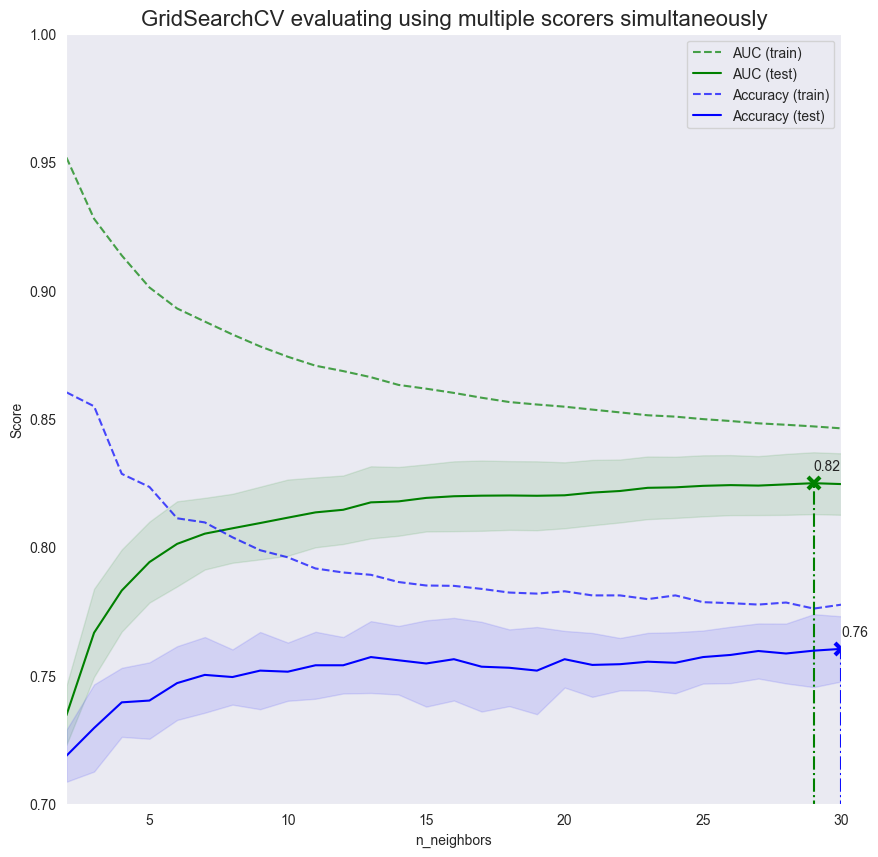

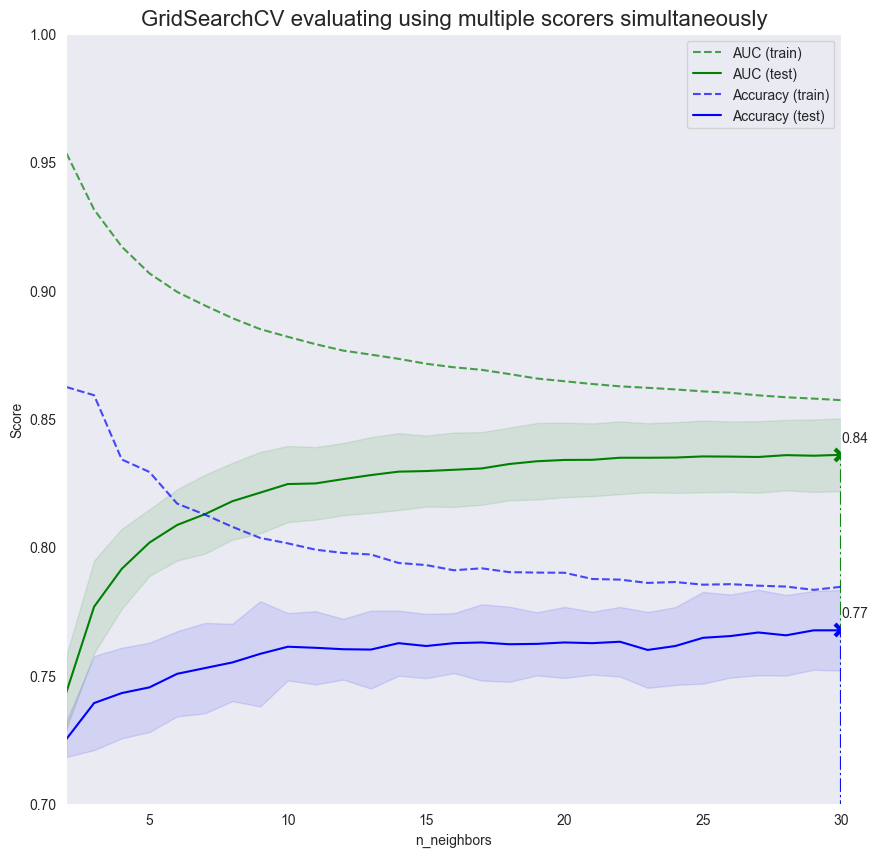

In [26]:
# Define the scorers
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

n_neighbours_param_min = 2
n_neighbours_param_max = 31
param_grid = {"n_neighbors": range(n_neighbours_param_min, n_neighbours_param_max, 1)}

results = multi_metric_cv(KNeighborsClassifier(p=2), scoring, X_train, y_train, param_grid)
plot_multi_score_cv_results("n_neighbors", n_neighbours_param_min, n_neighbours_param_max, 0.7, 1, results, "param_n_neighbors", int, scoring)

results = multi_metric_cv(KNeighborsClassifier(p=1), scoring, X_train, y_train, param_grid)
plot_multi_score_cv_results("n_neighbors", n_neighbours_param_min, n_neighbours_param_max, 0.7, 1, results, "param_n_neighbors", int, scoring)